In [33]:
from IPython.display import HTML
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from math import pi, cos, sin, acos, asin, atan2, sqrt
import numpy as np
from numpy import linalg as LA
import random
%matplotlib inline

In [34]:
# Constants
SAFE_ZONE = -1
PRED = "PRED"
PREY = "PREY"

In [109]:
# TODO Def can redesign the simulation to be more intutive with current functionality. Some game paradigms would be really helpful here
# as opposed to all the vector calc
# TODO So this is basically eye placement within a monty carlo simulation. I need to talk to an ecology person to get
# some ideas on actual animal behavior
# TODO The evolution process should be animated

In [36]:
# Create Eye Class
class Eye:
    def __init__(self, eye_arclength):
        # Height of the triangle
        self.direction = 8
        self.width = 6
        self.area = (self.direction * self.width)/2
        self.eye_arclength = eye_arclength

In [37]:
new_eye = Eye(pi/2)
assert new_eye.area == 24

In [38]:
# Create Grid
class Grid:
    def __init__(self):
        self.x_axis = 100
        self.y_axis = 100
    
    def print(self):
        print(grid)
    
    def valid_move(self, x, y):
        return(x > 0 and y > 0 and x + 1 <= self.x_axis and y + 1 <= self.y_axis)

A few problems to think about

How do I control where the eyes are located
How do I tell the direction the animal is facing
How do I allow the animal to move in relation to the direction its facing

Instead of doing a matrix format of the grid I'm going to do where the grid itself is just two numbers that represent the dimensions. The animal will operate in midpoints on movement.
Example:

Let location = [.5, .5]

If the animal moves left the value will be [1.5, .5]

The animal will also have a front point that will act to tell its direction.
The front point is an angle in relation to the x-axis.

Example:
Let front = PI
To calculate the front point we can then do cos(PI), sin(PI)

The eyes of the animal will be an arclength away from the front point.
Let front = PI
eye1_arclength = .5

Since the animal is essentially a unit circle:
front_arc_length = PI
eye1_arclength = PI + .5

Finding the point of the eye is then trivial
cos(eye1_arclength) + location[0], sin(eye1_arclength) + location[1]

Then looking is just a matter of building a triangle from the eye and finding if anything lies within it's area


The grid needs to know about all the animals so that it can tell when the game should be over. The grid is going to ask the animals for there location check and check for a winner at the end of each move

In [39]:
# Create Agent Action Class
class Animal:
    def __init__(self, eyes, role):
        self.role = role
        self.location = [.5,.5]
        self.direction_angle = (3*pi)/2
        # Eye Arc Lengths
        self.eyes = eyes
        self.score = 0
        
    # Returns tuples of ordered pairs for the location of the eyes
    def calc_eyes(self):
        # Calculate the position for an eye and return a tuple of the coordinates
        def calc_eye(eye):
            x = cos(abs(self.direction_angle + eye.eye_arclength)) + self.location[0]
            y = sin(abs(self.direction_angle + eye.eye_arclength)) + self.location[1]
            return((x, y))
        return(list(map(calc_eye, [eye for eye in self.eyes])))
         
    # The animal is allowed to turn it's body in any direction
    def turn(self, grid, angle, animal_found = False):
        self.direction_angle = (self.direction_angle + angle) % (2*pi)
    
    def decide_move(self, grid, angle, animal_found = False):
        random.seed()
        if(not animal_found):
            angle = random.uniform(0, 6.24)
            decided = random.choice([self.turn, self.move])
            decided(grid, angle, animal_found)
        else:
            self.move(grid, angle, animal_found)

    # The animal is allowed to move 1 in any direction
    def move(self, grid, angle, animal_found = False):
        if(animal_found and self.role == PREY):
            angle += pi
        x = cos(angle) + self.location[0]
        y = sin(angle) + self.location[1]
        if(grid.valid_move(x, y)):
            self.location[0] = x
            self.location[1] = y
            return True
        return False
    
#     # Look
#     def look():
#         for eye in calc_eyes():
            

In [41]:
# Tests - TODO Outdated
firstGrid = Grid()
pred = Animal(Eye, PREY)

# The animal turns correctly
pred.turn(pi)
assert pred.direction_angle == pi/2
# The animal moves correctly
pred.move(firstGrid, 2*pi)

assert pred.location[0] == cos(2*pi) + .5

TypeError: turn() missing 1 required positional argument: 'angle'

In [ ]:
# Sim Control - Yea this is gonna have to be redone
class simulation_control():
    def __init__(self, Grid, Animal, prey_eyes, pred_eyes):
        self.grid = Grid()
        self.animals = [Animal(prey_eyes, PREY), Animal(pred_eyes, PRED)]
        self.safe_zone = ([20,15],[20,15])
        # Set the iterations
        self.iterations = 20
        for animal in self.animals:
            animal.location[0] = random.randint(1,20)
            animal.location[1] = random.randint(1,20)


    # Helper funcs
    def animal_in_area(self, triangle_vectors, current_animal):
        # Check if the animal is within the 3 points
        for animal in (set(self.animals).symmetric_difference(set([current_animal]))):
            vector_directions = []
            for vector in triangle_vectors:
                vector_directions.append(np.cross(animal.location, vector))
            normalized = [direction/sqrt(sum([direction**2 for direction in vector_directions])) for direction in vector_directions]
            direction = [normal > 0 for normal in normalized]
            return direction[0] == direction[1] == direction[2]
        # Not quite the most efficient way, but it'll do for now
    
    def turn(self, animal):
        other_animal_rel_location, distance = self.look(animal)
        # Look to see if that animal won or lost
        if(distance < 1.2 and animal.role == PRED):
            print("Prey slaughtered")
            print(animal.location)
            for animal in self.animals:
                if(animal.role == PRED):
                    animal.score += 1
                else:
                    animal.score -= 1
            return(True)
        # Tell the animal to figure out where to move
        animal.decide_move(self.grid, other_animal_rel_location, not (other_animal_rel_location==False))
        return(False)
            
            
    def look(self, current_animal):
        for animal in self.animals:
            if(animal == current_animal):
                continue;
            angle = -1
            # Get the eye location area
            for eye in animal.calc_eyes():
                triangle_vectors = [(eye[0], eye[1]), (eye[0] + 8, eye[1] + 3), (eye[0] + 8, eye[1] - 3)]
                # Check if another animal is present
                if(self.animal_in_area(triangle_vectors, animal)):
                    # Tell that animal where the other animal is relative to it
                    angle = atan2(animal.location[1], animal.location[0])
                    distance = sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
                    return((angle, distance))
            return(False, 200)
                
            
    def animal_locations(self):
        return([animal.location for animal in self.animals])

    def ending_score(self, current_animal):
        for animal in self.animals:
            if animal == current_animal:
                continue;
            if(current_animal.role == PRED):
                current_animal.score -= sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
            else:
                current_animal.score += sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
    
    def start_sim(self):
        # Run the iterations
        for iteration in range(self.iterations):
            for animal in self.animals:
                turn = self.turn(animal)
                c = "red" if animal.role != PREY else "blue"
                # print(animal.role, ": ", animal.score, ": ", animal.location)
                plt.plot(animal.location[0], animal.location[1], 'ro', c=c, markersize=60)
                for eye in animal.calc_eyes():
                    # print(eye)
                    plt.plot(eye[0], eye[1], 'ro', c="green", markersize=.9)
            if(turn):
                break;
        for animal in self.animals:
            self.ending_score(animal)
        # plt.show()
        return(self.animals[0].score, self.animals[1].score)
            
        

-4.366604216591043
PREY :  0 :  [14, 16]
(14.397897932852056, 16.917429689421517)
(14.944140599320857, 15.670457091239923)
PRED :  0 :  [1.6585046078685182, 6.752576694706878]
(1.1120125751424954, 5.915112392084384)
(0.8898426817737805, 7.392231948239848)
PREY :  0 :  [14, 16]
(13.051444097414638, 15.683390303890626)
(14.246190806603506, 16.96922138169972)
PRED :  0 :  [2.3170092157370363, 7.505153389413756]
(1.7705171830110136, 6.667689086791262)
(1.5483472896422987, 8.144808642946726)
PREY :  0 :  [14.337987241993636, 16.941150691573636]
(13.389431339408274, 16.624540995464262)
(14.584178048597142, 17.910372073273358)
PRED :  0 :  [2.963034621434977, 8.268469297274198]
(2.416542588708954, 7.431004994651704)
(2.1943726953402396, 8.908124550807168)
PREY :  0 :  [14.337987241993636, 16.941150691573636]
(14.420113144533016, 17.937772654070997)
(15.337948403755355, 16.932337351222046)
PRED :  0 :  [3.609060027132918, 9.03178520513464]
(3.062567994406895, 8.194320902512146)
(2.840398101038

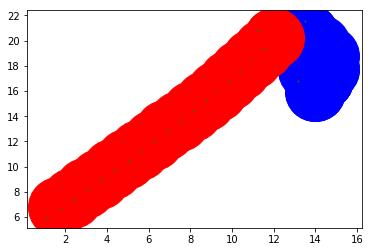

(0.19267804425149304, -0.19267804425149304)

In [99]:
eye_pair = (Evolve.random_eye_pair(), Evolve.random_eye_pair())
print(eye_pair[0][0].eye_arclength)
simulation_control(Grid, Animal, eye_pair[0], eye_pair[1]).start_sim()

In [100]:
class Evolve():
    def random_eye_pair():
        return((Eye(random.uniform(-6.24, 6.24)), Eye(random.uniform(-6.24, 6.24))))
    
    def breed_eye(eye_pair1, eye_pair2):
        return((Eye((eye_pair1[0].eye_arclength + eye_pair2[0].eye_arclength)/2), Eye((eye_pair1[1].eye_arclength + eye_pair2[1].eye_arclength)/2)))
    
    
    def mutate(eye_pair):
        chance_of_mutation = .01
        if random.random() < chance_of_mutation:
            eye_pair[0].eye_arclength += random.uniform(-6.24, 6.24)
            eye_pair[1].eye_arclength += random.uniform(-6.24, 6.24)
        return(eye_pair)

In [101]:
# So we are going to have a predator population that will one on one with a prey population at random
# The eye_placement for 1 and 2 will be random initally, but will undergo both breeding and mutation
init_pop = 50
prey_population = [Evolve.random_eye_pair() for item in range(init_pop)]
pred_population = [Evolve.random_eye_pair() for item in range(init_pop)]


In [111]:
simulation = [(eye_pair_pair[0], eye_pair_pair[1], simulation_control(Grid, Animal, eye_pair_pair[0], eye_pair_pair[1]).start_sim())  for eye_pair_pair in zip(prey_population, pred_population)]

In [110]:
# So we are going to have a predator population that will one on one with a prey population at random
# The eye_placement for 1 and 2 will be random initally, but will undergo both breeding and mutation
init_pop = 100
prey_population = [Evolve.random_eye_pair() for item in range(init_pop)]
pred_population = [Evolve.random_eye_pair() for item in range(init_pop)]
# print(prey_population)
while(init_pop > 10):
    # Select 50% of the population
    results = [(eye_pair_pair[0], eye_pair_pair[1], simulation_control(Grid, Animal, eye_pair_pair[0], eye_pair_pair[1]).start_sim())  for eye_pair_pair in zip(prey_population, pred_population)]    
    prey_population = [result[0] for result in sorted(results, key=lambda result: result[2][0])[:int(init_pop*.5)]]
    pred_population = [result[1] for result in sorted(results, key=lambda result: result[2][1])[:int(init_pop*.5)]]

    #  Then select 10% randomly
    raw_prey = [result[0] for result in results]
    raw_pred = [result[1] for result in results]
    random.shuffle(raw_prey)
    random.shuffle(raw_pred)
    prey_population += raw_prey[:10]
    pred_population += raw_pred[:10]
    if(len(prey_population) % 2 != 0):
        prey_population.pop()
    if(len(pred_population) % 2 != 0):
        pred_population.pop()
    half_index = int(len(prey_population)/2)
    prey_pairs = zip(prey_population[:half_index], prey_population[half_index:])
    pred_pairs = zip(pred_population[:half_index], pred_population[half_index:])

    init_pop = init_pop * .6
    if(init_pop <= 10):
        break
    # Eyes mix
    child_eye_preys = [Evolve.breed_eye(eye_pair[0], eye_pair[1]) for eye_pair in prey_pairs]
    child_eye_preds = [Evolve.breed_eye(eye_pair[0], eye_pair[1]) for eye_pair in pred_pairs]
    # Run them through potential mutation
    prey_population = [Evolve.mutate(eye_pair) for eye_pair in child_eye_preys + child_eye_preys[:9]]
    pred_population = [Evolve.mutate(eye_pair) for eye_pair in child_eye_preds + child_eye_preds[:9]]


In [104]:
eye_lengths = [(eye_pair[0].eye_arclength, eye_pair[1].eye_arclength) for eye_pair in pred_population]

In [105]:
results[0]

((<__main__.Eye at 0x107699438>, <__main__.Eye at 0x107699470>),
 (<__main__.Eye at 0x107d80ac8>, <__main__.Eye at 0x107d80b38>),
 (11.168904168660202, -11.168904168660202))

Prey Results
Score:  11.168904168660202


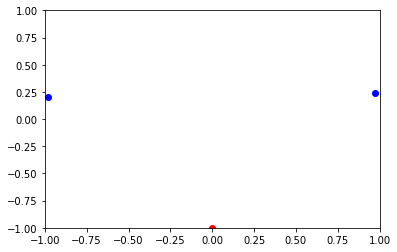

Pred Results
Score:  -11.168904168660202


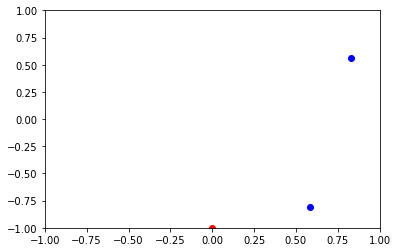

Prey Results
Score:  34.24251931709009


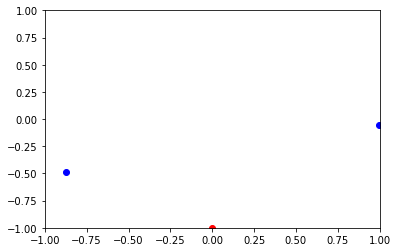

Pred Results
Score:  -34.24251931709009


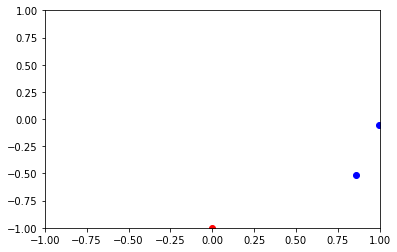

Prey Results
Score:  23.908438627623955


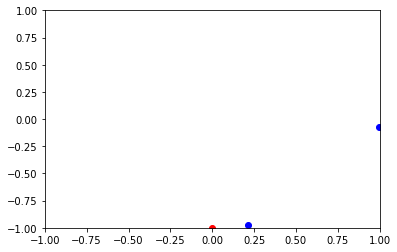

Pred Results
Score:  -23.908438627623955


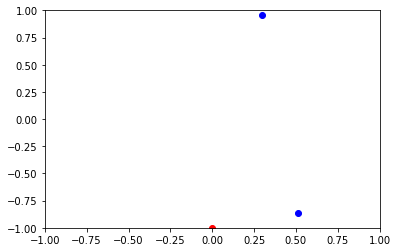

Prey Results
Score:  16.695138180170183


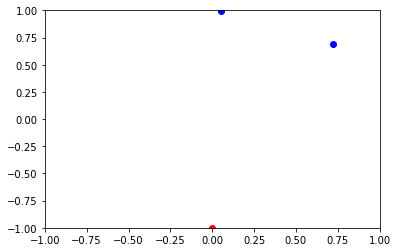

Pred Results
Score:  -16.695138180170183


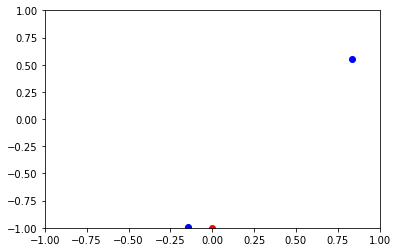

Prey Results
Score:  11.909443370461627


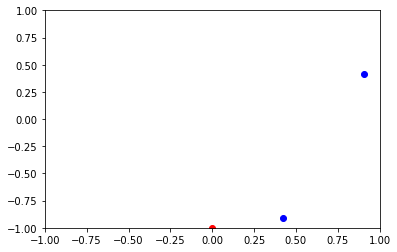

Pred Results
Score:  -11.909443370461627


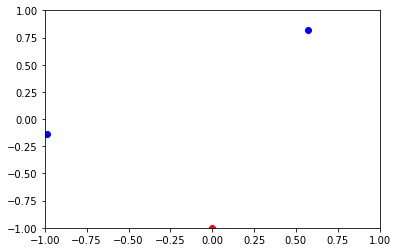

Prey Results
Score:  19.22796043798846


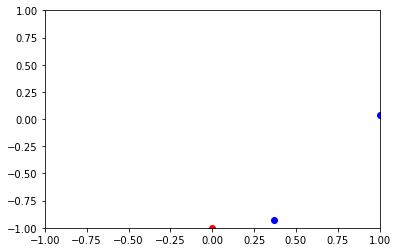

Pred Results
Score:  -19.22796043798846


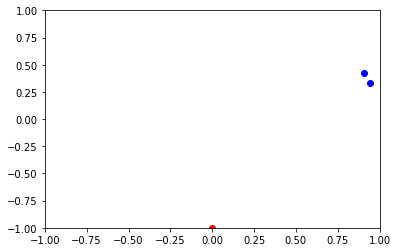

Prey Results
Score:  27.665329154099386


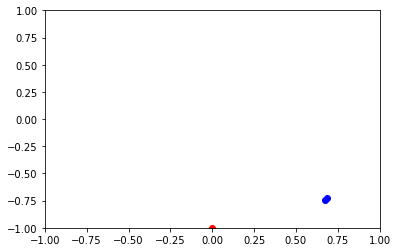

Pred Results
Score:  -27.665329154099386


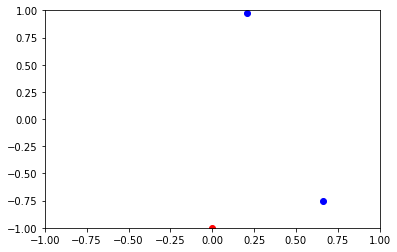

Prey Results
Score:  13.729890229483866


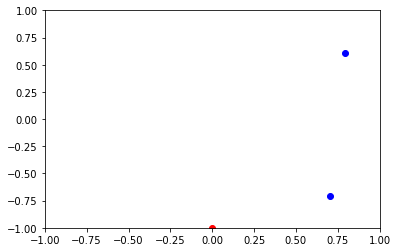

Pred Results
Score:  -13.729890229483866


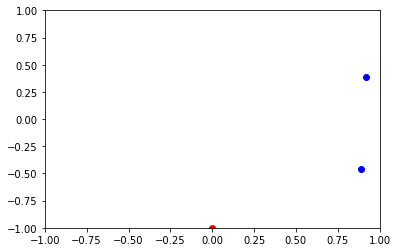

Prey Results
Score:  28.991368432909994


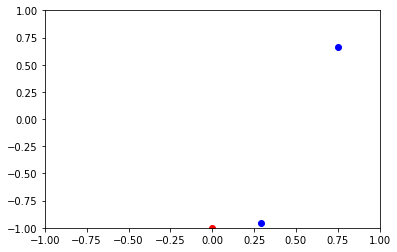

Pred Results
Score:  -28.991368432909994


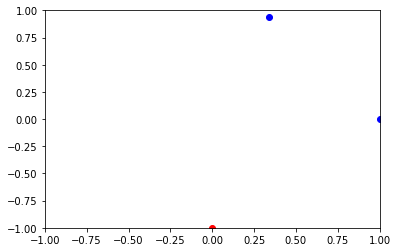

Prey Results
Score:  26.525131131205416


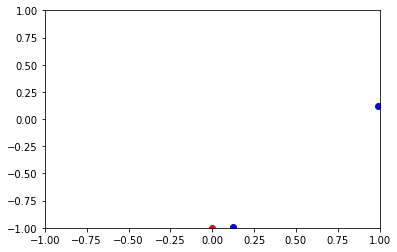

Pred Results
Score:  -26.525131131205416


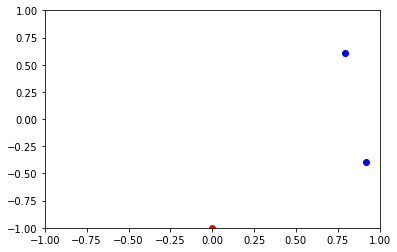

Prey Results
Score:  21.292203845265135


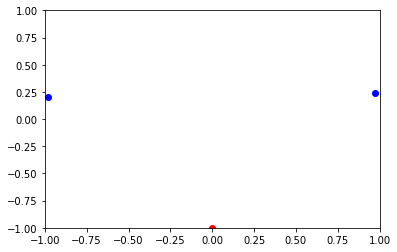

Pred Results
Score:  -21.292203845265135


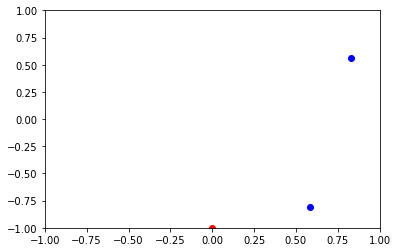

Prey Results
Score:  8.823373665264361


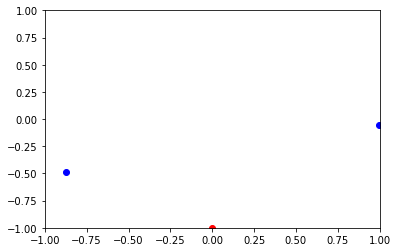

Pred Results
Score:  -8.823373665264361


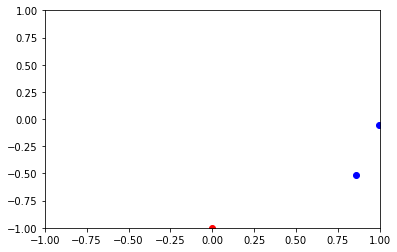

Prey Results
Score:  28.42938219967944


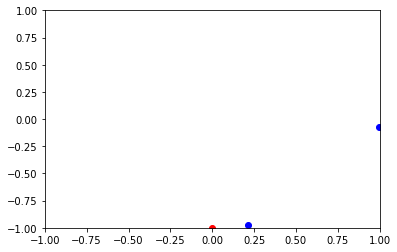

Pred Results
Score:  -28.42938219967944


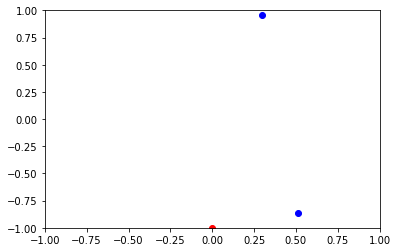

Prey Results
Score:  38.412746721167736


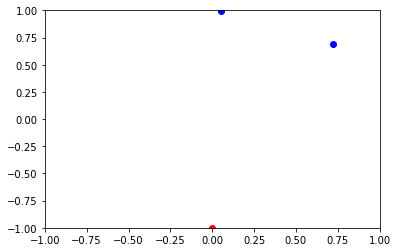

Pred Results
Score:  -38.412746721167736


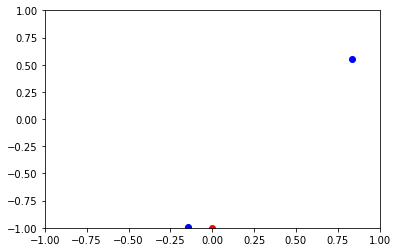

Prey Results
Score:  32.18305589016721


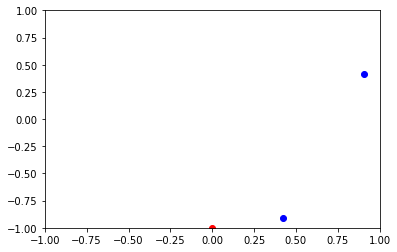

Pred Results
Score:  -32.18305589016721


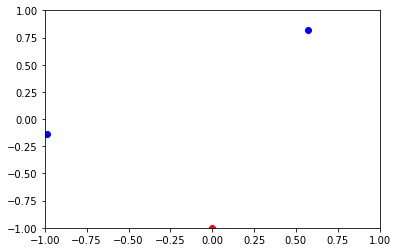

Prey Results
Score:  12.859320706203917


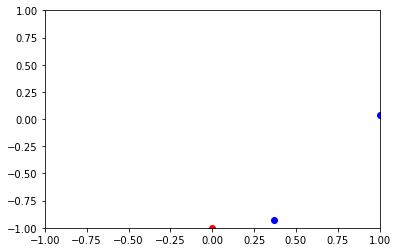

Pred Results
Score:  -12.859320706203917


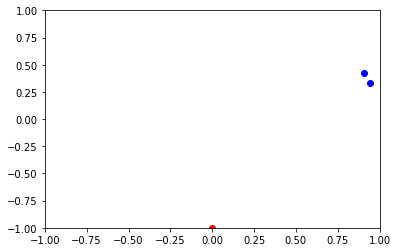

Prey Results
Score:  21.566368081063388


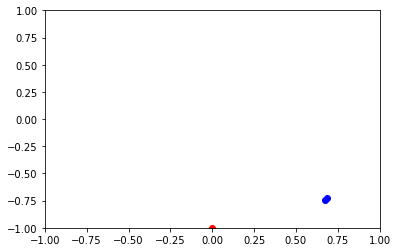

Pred Results
Score:  -21.566368081063388


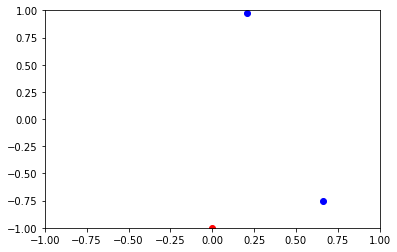

Prey Results
Score:  34.98543247323231


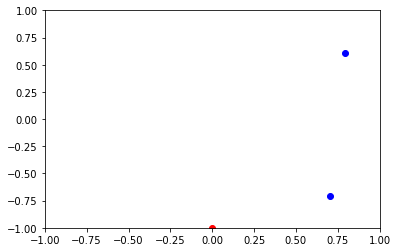

Pred Results
Score:  -34.98543247323231


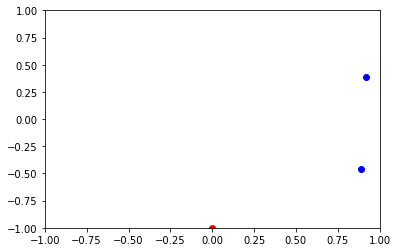

Prey Results
Score:  11.760988742071136


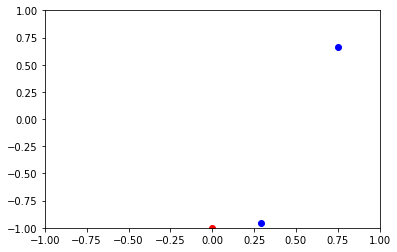

Pred Results
Score:  -11.760988742071136


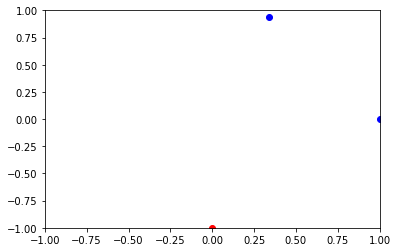

In [106]:
for result in results:
    # Output Prey Results
    print("Prey Results")
    print("Score: ", result[2][0])
    plt.plot(cos((3*pi)/2), sin((3*pi)/2), 'ro', c="red")    
    plt.plot(cos(result[0][0].eye_arclength), sin(result[0][0].eye_arclength), 'ro', c="blue") 
    plt.plot(cos(result[0][1].eye_arclength), sin(result[0][1].eye_arclength), 'ro', c="blue")
    # print(sqrt((cos(result[0][0].eye_arclength) - cos(result[0][1].eye_arclength))**2 +(sin(result[0][0].eye_arclength) - sin(result[0][1].eye_arclength))**2))
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.show()
    
    # Output Pred Results
    print("Pred Results")
    print("Score: ", result[2][1])
    plt.plot(cos((3*pi)/2), sin((3*pi)/2), 'ro', c="red")    
    plt.plot(cos(result[1][0].eye_arclength), sin(result[1][0].eye_arclength), 'ro', c="blue")    
    plt.plot(cos(result[1][1].eye_arclength), sin(result[1][1].eye_arclength), 'ro', c="blue")    
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.show()


In [107]:
avg_prey_length = sum([abs(result[0][0].eye_arclength - result[0][1].eye_arclength) for result in results])/(len(result))%((3*pi)/2)
avg_prey_length

4.322902781206455

In [108]:
avg_pred_length = sum([abs(result[1][0].eye_arclength - result[1][1].eye_arclength) for result in results])/(len(result))%((3*pi)/2)
avg_pred_length

0.4037317126611448